In [28]:
import os
import sys
import delta
from pyspark.sql.window import Window
import pyspark.sql.functions as psf
import pandas as pd
import pyspark.sql
from pyspark.sql.types import StructType, StructField, DateType, \
    StringType, DoubleType, TimestampType
import matplotlib.pyplot as plt

# sys.path.insert(0, os.path.abspath('./source/Producto_DIA_DP'))

from SparkDBUtils import SparkDB
sparkdb = SparkDB()
spark = sparkdb.spark

In [4]:
spark.sql("show schemas").show(truncate=False)

+----------------+
|namespace       |
+----------------+
|analisis_precios|
|default         |
|producto_dia    |
+----------------+



In [5]:
spark.sql("show tables in producto_dia").show(truncate=False)

+------------+---------------+-----------+
|namespace   |tableName      |isTemporary|
+------------+---------------+-----------+
|producto_dia|producto_dim   |false      |
|producto_dia|sequences_cfg  |false      |
|producto_dia|staging_product|false      |
+------------+---------------+-----------+



In [2]:
df = spark.table("producto_dia.staging_product").toPandas()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_producto  0 non-null      object
 1   url_product  0 non-null      object
 2   index        0 non-null      int32 
dtypes: int32(1), object(2)
memory usage: 0.0+ bytes


In [2]:
df = spark.table("producto_dia.producto_dim").toPandas()
df.info()

c:\users\carlos\proyectos\foodecommercescraper\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   product_id  8582 non-null   object        
 1   product     7801 non-null   object        
 2   brand       7801 non-null   object        
 3   categories  8582 non-null   object        
 4   units       8110 non-null   object        
 5   price       8110 non-null   float64       
 6   unit_price  8110 non-null   float64       
 7   discount    0 non-null      float64       
 8   date        8582 non-null   object        
 9   ts_load     8582 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 670.6+ KB


In [4]:
df.head()

,product_id,product,brand,categories,units,price,unit_price,discount,date,ts_load
0,223231,Queso fresco sin lactosa,Dia,"[Charcutería y quesos, Quesos fresco]",€/KILO),1.68,6.72,NaN,2023-09-12,2023-09-12 06:29:40.991637
1,224474,Ensalada mezclum,Vegecampo,"[Verduras, Verduras y ensaladas preparadas]",€/KILO),0.95,6.33,NaN,2023-09-12,2023-09-12 06:29:41.358288
2,225399,Mini barritas de chocolate con caramelo y caca...,Snickers,"[Azúcar. chocolates y caramelos, Chocolates y ...",€/KILO),2.29,15.90,NaN,2023-09-12,2023-09-12 06:29:41.619678
3,225767,Tinte casta,Nutrisse,"[Perfumería. higiene. salud, Tintes]",€/UNIDAD),5.89,5.89,NaN,2023-09-12,2023-09-12 06:29:41.847959
4,226508,Pizza serrana,Al,"[Pizzas y platos preparados, Pizzas]",€/KILO),2.69,6.90,NaN,2023-09-12,2023-09-12 06:29:42.122930


In [83]:
duplicates = df.groupby("product_id")["product_id"]\
    .count()\
    .loc[lambda x : x >= 2]\
    .index

df[df.product_id.isin(duplicates)].sort_values(by="product_id")


,product_id,product,brand,categories,units,price,unit_price,discount,date,ts_load
1000,100604,Yogur sabores,Dia,"[Yogures y postres, Yogures de sabores y frutas]",€/KILO),2.60,1.30,NaN,2023-09-12,2023-09-12 06:22:29.958660
8507,100604,Yogur sabores,Dia,"[Yogures y postres, Yogures de sabores y frutas]",€/KILO),2.60,1.30,NaN,2023-09-12,2023-09-12 06:07:46.482290
8508,101751,Crema de cacao con avellanas original,Nocilla,"[Café. cacao e infusiones, Cremas de cacao]",€/KILO),3.49,9.69,NaN,2023-09-12,2023-09-12 06:07:46.888511
1001,101751,Crema de cacao con avellanas original,Nocilla,"[Café. cacao e infusiones, Cremas de cacao]",€/KILO),3.49,9.69,NaN,2023-09-12,2023-09-12 06:22:30.328794
1002,102899,Vino blanco joven,Rueda,"[Cervezas. vinos y bebidas con alcohol, Vino b...",€/LITRO),4.50,6.00,NaN,2023-09-12,2023-09-12 06:22:30.684635
...,...,...,...,...,...,...,...,...,...,...
1572,273990,Lavavajillas mano concentrado limón,Super,"[Limpieza y hogar, Lavavajillas]",€/LITRO),1.99,1.99,NaN,2023-09-12,2023-09-12 06:23:35.342087
8405,274017,Suavizante concentrado floral,Super,"[Limpieza y hogar, Cuidado de la ropa]",€/LAVADO),2.15,0.03,NaN,2023-09-12,2023-09-12 06:10:12.755767
1573,274017,Suavizante concentrado floral,Super,"[Limpieza y hogar, Cuidado de la ropa]",€/LAVADO),2.15,0.03,NaN,2023-09-12,2023-09-12 06:23:35.656558
8406,274063,Lomo embuchado,Nuestra,"[Charcutería y quesos, Lomo. chorizo. fuet. sa...",€/KILO),2.69,19.21,NaN,2023-09-12,2023-09-12 06:10:13.099517


In [65]:
s

Series([], Name: product_id, dtype: int64)

<AxesSubplot: xlabel='x'>

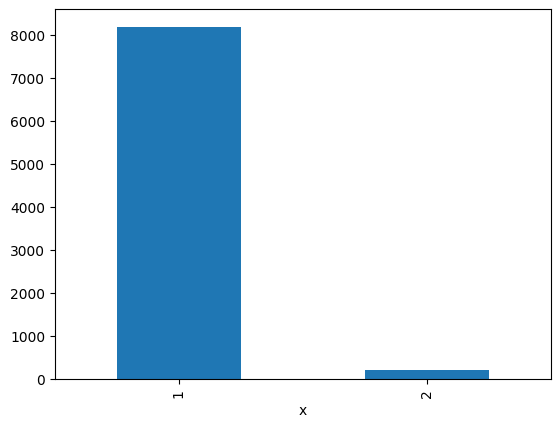

In [55]:
df2 = df.groupby("product_id")["product_id"].agg(x=("count"))

#df2.groupby("x").agg(tot=("x","count")).plot(kind="bar")

df2.groupby("x")["x"].count().plot(kind="bar")

# DELETE producto_dia.staging_product

In [4]:
dt = delta.DeltaTable.forName(spark, "producto_dia.staging_product")

In [5]:
dt.delete(psf.column("index") > "112")

In [8]:
dt.toDF().toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_producto  113 non-null    object
 1   url_product  113 non-null    object
 2   index        113 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 2.3+ KB


# DELETE producto_dia.producto_dim

In [3]:
dt = delta.DeltaTable.forName(spark, "producto_dia.producto_dim")

In [4]:
dt.delete()

In [5]:
dt.toDF().show()

+----------+-------+-----+----------+-----+-----+----------+--------+----+-------+
|product_id|product|brand|categories|units|price|unit_price|discount|date|ts_load|
+----------+-------+-----+----------+-----+-----+----------+--------+----+-------+
+----------+-------+-----+----------+-----+-----+----------+--------+----+-------+

